In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
from queries import start_elastic_search, index_documents
from trec_files import make_trec_run
from trec_files import read_eval_files
from evaluation import trec_eval
from evaluation import mean_average_precision
from evaluation import print_trec_eval
import elasticsearch
import elasticsearch.helpers
import json
from elasticsearch import Elasticsearch
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from elasticsearch_dsl import Q
from elasticsearch_dsl import Search
import numpy as np
import matplotlib.pyplot as plt

print("done")

done


In [4]:
# Connect to the ElasticSearch server
es = elasticsearch.Elasticsearch(host='localhost')  # in case you use Docker, the host is 'elasticsearch'

# Index the collection into the index called 'genomics'
body = {} # no indexing options (leave default)
index_documents(es, 'data01/FIR-s05-medline.json', 'genomics-base', body)

/home/ut-student/.local/lib/python3.8/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


(263080, [])

In [10]:
# connect to ES server             
es = elasticsearch.Elasticsearch('localhost')

# Write the results of the queries contained in the topic file `'data/training-queries-simple.txt'` 
# to the run file `'baseline.run'`, and name this test as `test01`
# make_trec_run(es, 'data01/FIR-s05-training-queries-simple.txt', 'baseline.run', "genomics-base", run_name='no_pseudo_01')

def pseudo_IR(i, j):
    make_trec_run(es, 'data01/FIR-s05-training-queries-simple.txt', 'baseline.run', "genomics-base", run_name='pseudo_01', pseudo_relevance=True, k_docs=i, terms_frac=j)

    results = trec_eval('data01/FIR-s05-training-qrels.txt', 'baseline.run')
    mean_average_precision = results[-1][1]
    
    return mean_average_precision

print("done")

done


In [16]:
results = []
map_per_doc = []
map_per_terms = []

for i in range(2, 21):
    for j in range(1, 21):
        # Call the IR function and append the result to the 'results' array
        result = pseudo_IR(i, j)
        results.append(result)
        print(f"Pseudo Docs count: {i:2d} Pseudo Terms Enhanced: {j:2d} MAP: {result:.3f}")

# Print or use the 'results' array as needed
# print(results)

Pseudo Docs count:  2 Pseudo Terms Enhanced:  1 MAP: 0.118
Pseudo Docs count:  2 Pseudo Terms Enhanced:  2 MAP: 0.124
Pseudo Docs count:  2 Pseudo Terms Enhanced:  3 MAP: 0.117
Pseudo Docs count:  2 Pseudo Terms Enhanced:  4 MAP: 0.122
Pseudo Docs count:  2 Pseudo Terms Enhanced:  5 MAP: 0.119
Pseudo Docs count:  2 Pseudo Terms Enhanced:  6 MAP: 0.123
Pseudo Docs count:  2 Pseudo Terms Enhanced:  7 MAP: 0.120
Pseudo Docs count:  2 Pseudo Terms Enhanced:  8 MAP: 0.116
Pseudo Docs count:  2 Pseudo Terms Enhanced:  9 MAP: 0.114
Pseudo Docs count:  2 Pseudo Terms Enhanced: 10 MAP: 0.112
Pseudo Docs count:  2 Pseudo Terms Enhanced: 11 MAP: 0.107
Pseudo Docs count:  2 Pseudo Terms Enhanced: 12 MAP: 0.113
Pseudo Docs count:  2 Pseudo Terms Enhanced: 13 MAP: 0.109
Pseudo Docs count:  2 Pseudo Terms Enhanced: 14 MAP: 0.109
Pseudo Docs count:  2 Pseudo Terms Enhanced: 15 MAP: 0.109
Pseudo Docs count:  2 Pseudo Terms Enhanced: 16 MAP: 0.104
Pseudo Docs count:  2 Pseudo Terms Enhanced: 17 MAP: 0.1

Pseudo Docs count:  8 Pseudo Terms Enhanced: 20 MAP: 0.097
Pseudo Docs count:  9 Pseudo Terms Enhanced:  1 MAP: 0.121
Pseudo Docs count:  9 Pseudo Terms Enhanced:  2 MAP: 0.123
Pseudo Docs count:  9 Pseudo Terms Enhanced:  3 MAP: 0.114
Pseudo Docs count:  9 Pseudo Terms Enhanced:  4 MAP: 0.122
Pseudo Docs count:  9 Pseudo Terms Enhanced:  5 MAP: 0.120
Pseudo Docs count:  9 Pseudo Terms Enhanced:  6 MAP: 0.122
Pseudo Docs count:  9 Pseudo Terms Enhanced:  7 MAP: 0.118
Pseudo Docs count:  9 Pseudo Terms Enhanced:  8 MAP: 0.117
Pseudo Docs count:  9 Pseudo Terms Enhanced:  9 MAP: 0.116
Pseudo Docs count:  9 Pseudo Terms Enhanced: 10 MAP: 0.117
Pseudo Docs count:  9 Pseudo Terms Enhanced: 11 MAP: 0.118
Pseudo Docs count:  9 Pseudo Terms Enhanced: 12 MAP: 0.114
Pseudo Docs count:  9 Pseudo Terms Enhanced: 13 MAP: 0.113
Pseudo Docs count:  9 Pseudo Terms Enhanced: 14 MAP: 0.108
Pseudo Docs count:  9 Pseudo Terms Enhanced: 15 MAP: 0.108
Pseudo Docs count:  9 Pseudo Terms Enhanced: 16 MAP: 0.1

Pseudo Docs count: 15 Pseudo Terms Enhanced: 19 MAP: 0.098
Pseudo Docs count: 15 Pseudo Terms Enhanced: 20 MAP: 0.096
Pseudo Docs count: 16 Pseudo Terms Enhanced:  1 MAP: 0.118
Pseudo Docs count: 16 Pseudo Terms Enhanced:  2 MAP: 0.121
Pseudo Docs count: 16 Pseudo Terms Enhanced:  3 MAP: 0.119
Pseudo Docs count: 16 Pseudo Terms Enhanced:  4 MAP: 0.121
Pseudo Docs count: 16 Pseudo Terms Enhanced:  5 MAP: 0.119
Pseudo Docs count: 16 Pseudo Terms Enhanced:  6 MAP: 0.121
Pseudo Docs count: 16 Pseudo Terms Enhanced:  7 MAP: 0.117
Pseudo Docs count: 16 Pseudo Terms Enhanced:  8 MAP: 0.117
Pseudo Docs count: 16 Pseudo Terms Enhanced:  9 MAP: 0.117
Pseudo Docs count: 16 Pseudo Terms Enhanced: 10 MAP: 0.120
Pseudo Docs count: 16 Pseudo Terms Enhanced: 11 MAP: 0.119
Pseudo Docs count: 16 Pseudo Terms Enhanced: 12 MAP: 0.113
Pseudo Docs count: 16 Pseudo Terms Enhanced: 13 MAP: 0.112
Pseudo Docs count: 16 Pseudo Terms Enhanced: 14 MAP: 0.108
Pseudo Docs count: 16 Pseudo Terms Enhanced: 15 MAP: 0.1

In [18]:
# In case results accidentely gets scrapped
backup_results = results

results_array = np.array(results)

# Save the array to a file (e.g., results.npy)
np.save('results2.npy', results_array)



# Now 'loaded_results_array' contains the same data as 'results_array'
print(loaded_results_array)

[0.12260028 0.1128694  0.11512228 0.10555121 0.10219651 0.10093988
 0.09884595 0.1008682  0.09383488 0.0954231  0.11918139 0.11137472
 0.10024516 0.09646836 0.09734683 0.08470204 0.08593144 0.08567331
 0.08857943 0.0827283  0.12172727 0.09897222 0.09106454 0.09733335
 0.10426592 0.10463166 0.0913445  0.09658737 0.09723599 0.09044177
 0.11464902 0.09309767 0.10367175 0.10572407 0.09117318 0.09303469
 0.09154379 0.08820646 0.0865642  0.07781557 0.10840191 0.08901433
 0.10100958 0.0883382  0.08955194 0.08800209 0.09031384 0.09198037
 0.08846918 0.08781606 0.10411379 0.09729898 0.10389879 0.0904727
 0.08779054 0.08202246 0.08717187 0.08820513 0.08520101 0.07603705
 0.1023174  0.09383236 0.10760803 0.08725213 0.09058687 0.08230755
 0.08305233 0.08137939 0.07727232 0.07619409 0.09323193 0.09273379
 0.10704028 0.08637447 0.0869417  0.0831856  0.07969364 0.07851045
 0.07434612 0.06963288 0.09154116 0.09282675 0.09398264 0.08380285
 0.08508028 0.07794164 0.07862561 0.07406285 0.0696586  0.06925

In [7]:
# To retrieve the array from the file
loaded_results_array = np.load('results2.npy')
results = loaded_results_array

In [43]:
# print(results_array)

docs_array = results_array
term_array = np.transpose(results_array)

mean_per_doc = []
mean_per_term = []

for i, docs in enumerate(docs_array):
    mean_per_doc.append(np.mean(docs))
    print(i+2, np.mean(docs))


for j, terms in enumerate(term_array):
    mean_per_term.append(np.mean(terms))
    print(j+1, np.mean(terms))
    



2 0.1117891354064499
3 0.11261917066512066
4 0.11237145258785317
5 0.1130453672577775
6 0.11285260042304479
7 0.11290741657687749
8 0.11290564783502133
9 0.112884245382104
10 0.11303391784823398
11 0.1130044596018385
12 0.11299755219423287
13 0.11306479229260018
14 0.11318847674916852
15 0.11256690773435785
16 0.11251880810540645
17 0.11233809508539702
18 0.11205383814454069
19 0.11182649536772912
20 0.11197550492294579
1 0.11900375944879386
2 0.121296006806288
3 0.11670466470946284
4 0.12186058425371778
5 0.1198695194687516
6 0.12078132872214366
7 0.11789473918251375
8 0.11685349424503824
9 0.11624288789822988
10 0.11815560674330065
11 0.1171353663197047
12 0.11445141027450347
13 0.11174682241202291
14 0.10820167409143366
15 0.10777515689981444
16 0.10463955523681302
17 0.10299480500822172
18 0.10052959008221547
19 0.09880496024693845
20 0.09763057761398651


In [ ]:
# results_array = np.array(results).reshape((len(range(2, 21)), len(range(1, 21))))

# print(results_array)

# Plot mean_average_precision as a function of i
plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
plt.plot(range(2, 21), results_array.mean(axis=1), marker='o')
plt.title('MAP against number of Docs included')
plt.xlabel('number of docs included')
plt.ylabel('Mean Average Precision')

# Plot mean_average_precision as a function of j
plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 2)
plt.plot(range(, 21), results_array.mean(axis=0), marker='o')
plt.title('MAP against percentage of terms included')
plt.xlabel('part of total terms included')
plt.ylabel('Mean Average Precision')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plots
plt.show()

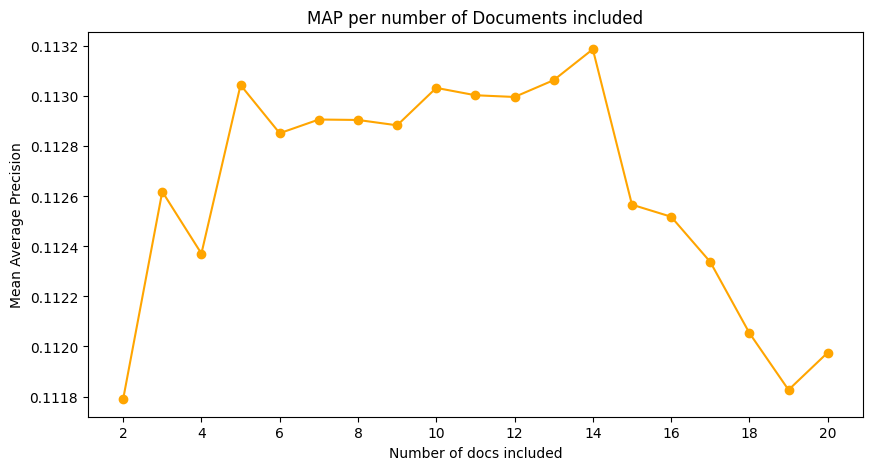

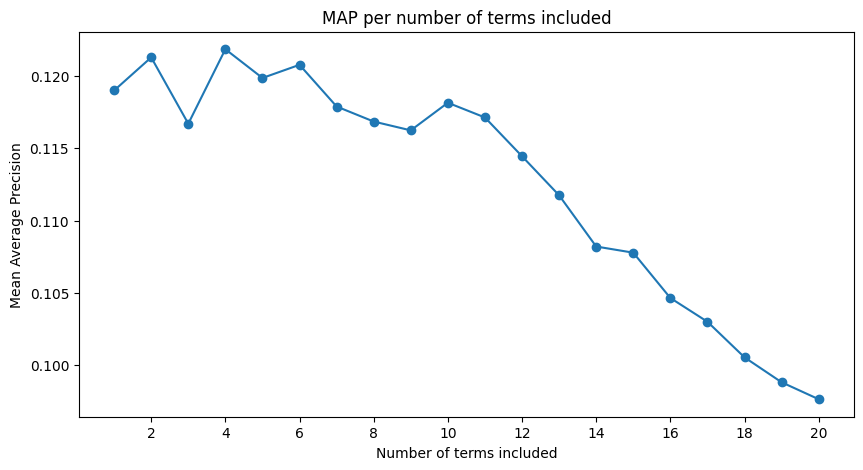

In [74]:
# Plot mean_average_precision as a function of i
plt.figure(figsize=(10, 5))
plt.plot(range(2, len(mean_per_doc)+2), mean_per_doc, marker='o', color='orange')
plt.xticks(np.arange(2, 21, 2))
plt.title('MAP per number of Documents included')
plt.xlabel('Number of docs included')
plt.ylabel('Mean Average Precision')

# Plot mean_average_precision as a function of j
plt.figure(figsize=(10, 5))

plt.plot(range(1,21), mean_per_term, marker='o')
plt.xticks(np.arange(2, 21, 2))
plt.title('MAP per number of terms included')
plt.xlabel('Number of terms included')
plt.ylabel('Mean Average Precision')

# # Adjust layout for better visualization
# plt.tight_layout()

# # Show the plots
plt.show()

# Pseudo-Feedback Relevance

In [ ]:
# Highest docs:
# Plot mean_average_precision as a function of i
plt.figure(figsize=(10, 5))
plt.plot(range(2, len(mean_per_doc)+2), mean_per_doc, marker='o', color='orange')
plt.xticks(np.arange(2, 21, 2))
plt.title('MAP per number of Documents included')
plt.xlabel('Number of docs included')
plt.ylabel('Mean Average Precision')

# Plot mean_average_precision as a function of j
plt.figure(figsize=(10, 5))

plt.plot(range(1,21), mean_per_term, marker='o')
plt.xticks(np.arange(2, 21, 2))
plt.title('MAP per number of terms included')
plt.xlabel('Number of terms included')
plt.ylabel('Mean Average Precision')

# # Adjust layout for better visualization
# plt.tight_layout()

# # Show the plots
plt.show()


## Evaluate